In [6]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import argparse
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import precision_score, recall_score, f1_score
from pandas import DataFrame
from sklearn.mixture import GaussianMixture as GM_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.simplefilter("ignore")

In [7]:
def calculate_dis_of_tp_and_vp_single(single_point, batch_point): #计算单个生成点到原始数据集所有点的距离(先算差值平方 → 再加和 → 最后开根号)
    b_s = (batch_point - single_point) ** 2
    su = np.sum(b_s, axis=1).astype(float)
    res = np.sqrt(su)
    return res

In [8]:
def calculate_dis_of_tp_and_vp_batch(created_data, origin_data):  #计算每个虚拟样本点与原始数据集中所有样本点之间的欧几里得距离
    res_sort_idx = np.zeros(shape=(len(created_data), len(origin_data)), dtype="int")   # 存放排序后的索引
    res = np.zeros(shape=(len(created_data), len(origin_data))) # 存放实际距离
    for i in range(len(created_data)):
        res_temp = calculate_dis_of_tp_and_vp_single(created_data[i, :], origin_data)
        res[i] = res_temp
        res_temp_sort_idx = np.argsort(res_temp)
        res_sort_idx[i] = res_temp_sort_idx
    return res, res_sort_idx

In [9]:
class GmmVSG:
    #创建 GmmVSG 对象时做准备工作
    def __init__(self, covariance_type='full', optimizer='aic', result_retain=4, seed=0):
        self.covariance_type = covariance_type  #控制 GMM 的协方差结构，决定模型灵活度
        self.optimizer = optimizer #选择用 AIC 还是 BIC 来选最优模型
        self.result_retain = result_retain  #虚拟样本保留几位小数
        self.random_seed = seed #种子数

        self.__gmmModel = None  # 用来存训练好的GMM模型
        self.__col_names = None # 存特征列的名字（列名）
        self.__targetName = None  # 标签列的列名
        self.__X = None # 原始特征数据
        self.__y = None  # 原始标签数据

    #读取原始数据，提取你指定的特征列（以及可选的标签列），并保存起来为后续训练 GMM 模型做准备。
    def fit(self, file_path, feature_start_idx, feature_end_idx, n_components, target_name=None): 
        if not os.path.exists(file_path):
            print("File path does not exist, please re-enter！")
            sys.exit(-1)
        df_data = pd.read_excel(file_path)

        if target_name is None:
            X = df_data.values
            self.__col_names = list(df_data.columns.values)
        else:
            self.__targetName = target_name
            X = df_data.values[:, feature_start_idx - 1:feature_end_idx]
            y = df_data[target_name].values
            self.__X = X
            self.__y = y
            temp_col_name = df_data.columns.values[feature_start_idx - 1:feature_end_idx]
            col_name = [i for i in temp_col_name]
            col_name.append(target_name)
            self.__col_names = col_name

        # 求GMM参数
        models = [GM_model(n, covariance_type=self.covariance_type, random_state=self.random_seed).fit(X)
                  for n in n_components] #批量训练多个 GMM 模型
        #选择最佳模型
        best_model_index = 0
        if self.optimizer.lower() == 'aic':
            score_aic = [m.aic(X) for m in models]
            best_model_index = np.argmin(score_aic)
        elif self.optimizer.lower() == 'bic':
            score_bic = [m.bic(X) for m in models]
            best_model_index = np.argmin(score_bic)
        else:
            print("There is no optimizer of this type, please confirm again!")
            exit(-1)

        # 保存最佳模型
        gmm = models[best_model_index]
        gmm.fit(X)
        self.__gmmModel = gmm

    def samples(self, number): #从训练好的 GMM 模型中 生成虚拟样本
        # 确认模型是否已训练
        if self.__gmmModel is None:
            print("fit() is needed before samples()!")
            exit(-1)
        VX = self.__gmmModel.sample(number)[0] #调用 GMM 生成新样本
        
        # 保存数据
        fmt = "%.0{}f".format(self.result_retain)
        if self.__targetName is None:

            data_frame = DataFrame(VX, columns=self.__col_names)
            return data_frame
        else:
            X, y = self.__X, self.__y
            s_scale = StandardScaler()
            s_scale.fit(X)
            standard_X = s_scale.transform(X)
            standard_VX = s_scale.transform(VX)
            _, sort_idx = calculate_dis_of_tp_and_vp_batch(standard_VX, standard_X)
            created_y = np.array([y[i[0]] for i in sort_idx])
            created_data = np.hstack((VX, created_y.reshape(-1, 1)))

            data_frame = DataFrame(created_data, columns=self.__col_names)
            return data_frame

In [13]:
path = "./level3.xlsx"
# path =r'C:\Users\la136\Desktop\23.xlsx'
parser = argparse.ArgumentParser()
parser.add_argument("--covariance_type", default="full", type=str, help="covariance type")
parser.add_argument("--optimizer", default="aic", type=str, help="method of how to select model")
parser.add_argument("--result_retain", default=4, type=int, help="Keep decimal places for results")
parser.add_argument("--seed", default=0, type=int, help="random seed")
parser.add_argument("--file_path", default=path, type=str)
parser.add_argument("--feature_start_idx", default=2, type=int)
parser.add_argument("--feature_end_idx", default=14, type=int)
parser.add_argument("--n_components", default=[i for i in range(1, 24, 1)], type=list)
parser.add_argument("--target_name", default="label", type=str)
args = parser.parse_args(args=[])
    
gmm_generator = GmmVSG(
    covariance_type=args.covariance_type,
    optimizer=args.optimizer,
    result_retain=args.result_retain,
    seed=args.seed
)
gmm_generator.fit(
    args.file_path,
    args.feature_start_idx,
    args.feature_end_idx,
    args.n_components,
    args.target_name
    )
test_4 = gmm_generator.samples(1000)
test_4.to_excel(r'C:\Users\la136\Desktop\3_1000.xlsx') 

In [26]:
import pandas as pd
# 1. 读取原始 Excel 文件
# test_4.loc[test_4['label'] == 4, 'label'] = 1
file_path = r"C:\Users\la136\Desktop\X.xlsx"
data = pd.read_excel(file_path, sheet_name='三分类不均衡')

# 2. 初始化空列表，逐类采样
sampled_list = []

# 3. 对 label = 0,1,2,3 各抽取1000条
for label_value in [0,1,2]:
    subset = data[data['label'] == label_value]
    sampled_subset = subset.sample(n=461)
    sampled_list.append(sampled_subset)


# label_0_data = data[data['label'] == 0]
# sampled_list.append(label_0_data)
# # 4. 对 label = 4，保留全部数据
# label_4_data = data[data['label'] == 1]
# sampled_list.append(label_4_data)
# sampled_list.append(test_4)
# 5. 合并所有采样后的数据
df = pd.concat(sampled_list, ignore_index=True)

# 6. 保存结果到新的 Excel 文件
# output_path = r"C:\Users\la136\Desktop\多分类5000.xlsx"
# final_sampled_data.to_excel(output_path, index=False)




数据类型检查：
Elevaton           int64
Slope              int64
Aspect             int64
Curvature          int64
TWI              float64
SPI              float64
LUT                int64
Distance         float64
Soil moisture    float64
CTI              float64
Roughness        float64
VRM              float64
TPI              float64
label              int64
dtype: object
Confusion Matrix:
[[131   3   4]
 [  4  71  63]
 [  5  63  71]]
Accuracy: 0.6578
Average Confidence: 0.8032
Macro Precision: 0.6562
Macro Recall: 0.6582
Macro F1-Score: 0.6571
Log Loss: 0.7658
Cohen's Kappa: 0.4867
MSE: 0.4072
RMSE: 0.6381

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       138
           1       0.52      0.51      0.52       138
           2       0.51      0.51      0.51       139

    accuracy                           0.66       415
   macro avg       0.66      0.66      0.66       415
weighted avg       0.66      0.66     

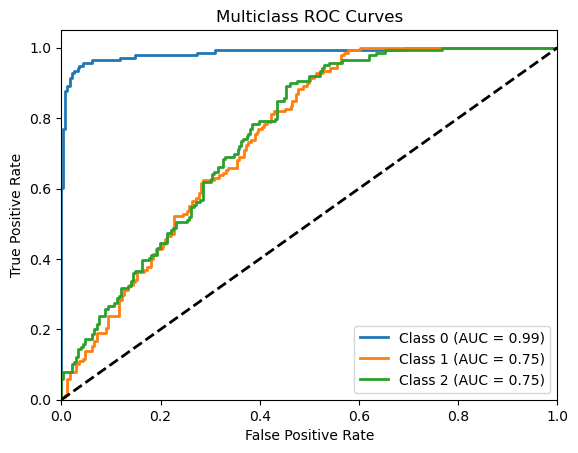

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, cohen_kappa_score, log_loss,
    classification_report, roc_auc_score, roc_curve, auc
)
from sklearn.metrics import mean_squared_error

# 1. 读取数据
data = df
# data= pd.read_excel(r"C:\Users\la136\Desktop\4000.xlsx")
target_column = "label"  # 你的目标变量列

# 2. 检查数据类型
print("数据类型检查：")
print(data.dtypes)

# 3. 编码字符串列
label_encoder = LabelEncoder()
if data[target_column].dtype == 'object':
    data[target_column] = label_encoder.fit_transform(data[target_column])

categorical_columns = data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col])

# 4. 划分训练/测试集
train_dataset, test_dataset = train_test_split(
    data,
    test_size=0.3,
    stratify=data[target_column],
    random_state=42
)

X_train = train_dataset.drop(columns=[target_column])
y_train = train_dataset[target_column]
X_test = test_dataset.drop(columns=[target_column])
y_test = test_dataset[target_column]

# 5. 模型初始化和训练
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

# # 定义 LSTM 模型
# model = Sequential()

# # 添加 LSTM 层
# model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))

# # 添加 Dropout 层以减少过拟合
# model.add(Dropout(0.2))

# # 添加输出层
# model.add(Dense(units=1, activation='sigmoid'))  # 如果是二分类问题，使用 sigmoid；多分类用 softmax

# # 编译模型
# model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])  # 适应二分类问题

# # 训练模型
# model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


# 6. 预测
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# 7. 混淆矩阵
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# 8. 指标评估
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
logloss = log_loss(y_test, y_pred_proba)
kappa = cohen_kappa_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# 置信度得分
confidence_scores = []
for i, pred in enumerate(y_pred):
    confidence_scores.append(y_pred_proba[i, pred])
average_confidence = np.mean(confidence_scores)

# 打印评估结果
print(f"Accuracy: {accuracy:.4f}")
print(f"Average Confidence: {average_confidence:.4f}")
print(f"Macro Precision: {precision:.4f}")
print(f"Macro Recall: {recall:.4f}")
print(f"Macro F1-Score: {f1:.4f}")
print(f"Log Loss: {logloss:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 9. 多分类ROC绘图（每个类 vs 其他类）
n_classes = len(np.unique(y_test))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘图
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend(loc="lower right")
plt.show()


数据类型检查：
Elevaton         float64
Slope            float64
Aspect           float64
Curvature        float64
TWI              float64
SPI              float64
LUT              float64
Distance         float64
Soil moisture    float64
CTI              float64
Roughness        float64
VRM              float64
TPI              float64
label              int64
dtype: object
Confusion Matrix:
[[544 169]
 [296 404]]
Accuracy: 0.6709
Average Confidence: 0.7858
Precision: 0.7051
Recall: 0.5771
F1-Score: 0.6347
Log Loss: 0.6056
Cohen's Kappa: 0.3407
MSE: 0.3291
RMSE: 0.5737

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.76      0.70       713
           1       0.71      0.58      0.63       700

    accuracy                           0.67      1413
   macro avg       0.68      0.67      0.67      1413
weighted avg       0.68      0.67      0.67      1413



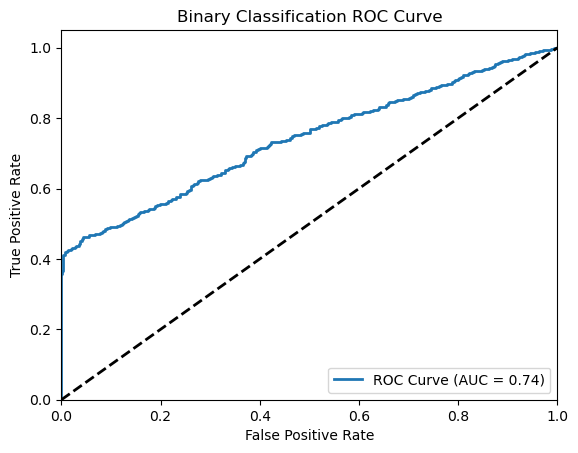

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, cohen_kappa_score, log_loss,
    classification_report, roc_auc_score, roc_curve,
    mean_squared_error
)

# 1. 读取数据
data = pd.read_excel(r"C:\Users\la136\Desktop\因子识别.xlsx",sheet_name='2_3')
target_column = "label"  # 目标变量

# 2. 检查数据类型
print("数据类型检查：")
print(data.dtypes)

# 3. 编码字符串列
label_encoder = LabelEncoder()
if data[target_column].dtype == 'object':
    data[target_column] = label_encoder.fit_transform(data[target_column])

categorical_columns = data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col])

# 确认是否为二分类
unique_classes = data[target_column].unique()
if len(unique_classes) != 2:
    raise ValueError("当前数据不是二分类，请确保 label 只有两个唯一值。")

# 4. 划分训练/测试集
train_dataset, test_dataset = train_test_split(
    data,
    test_size=0.3,
    stratify=data[target_column]
)

X_train = train_dataset.drop(columns=[target_column])
y_train = train_dataset[target_column]
X_test = test_dataset.drop(columns=[target_column])
y_test = test_dataset[target_column]

# 5. 模型初始化和训练
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# # 定义 LSTM 模型
# model = Sequential()

# # 添加 LSTM 层
# model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))

# # 添加 Dropout 层以减少过拟合
# model.add(Dropout(0.2))

# # 添加输出层
# model.add(Dense(units=1, activation='sigmoid'))  # 如果是二分类问题，使用 sigmoid；多分类用 softmax

# # 编译模型
# model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])  # 适应二分类问题

# # 训练模型
# model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


# 6. 预测
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # 二分类：取正类的概率

# 7. 混淆矩阵
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# 8. 指标评估
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
logloss = log_loss(y_test, y_pred_proba)
kappa = cohen_kappa_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# 置信度得分
confidence_scores = []
for i, pred in enumerate(y_pred):
    confidence = y_pred_proba[i] if pred == 1 else 1 - y_pred_proba[i]
    confidence_scores.append(confidence)
average_confidence = np.mean(confidence_scores)

# 打印评估结果
print(f"Accuracy: {accuracy:.4f}")
print(f"Average Confidence: {average_confidence:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Log Loss: {logloss:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 9. ROC 曲线绘制（二分类）
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binary Classification ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# 1. 加载数据
# data = pd.read_excel(r"C:\Users\la136\Desktop\2重投顺利\数据集\多分类训练.xlsx", sheet_name='三分类均衡') 
data=df
target_column = "label"

# 2. 编码非数值列
label_encoder = LabelEncoder()
if data[target_column].dtype == 'object':
    data[target_column] = label_encoder.fit_transform(data[target_column])

categorical_columns = data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col])

X = data.drop(columns=[target_column])
y = data[target_column]

# 3. 初始化模型和交叉验证
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
# # 定义 LSTM 模型
# model = Sequential()

# # 添加 LSTM 层
# model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))

# # 添加 Dropout 层以减少过拟合
# model.add(Dropout(0.2))

# # 添加输出层
# model.add(Dense(units=1, activation='sigmoid'))  # 如果是二分类问题，使用 sigmoid；多分类用 softmax

# # 编译模型
# model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])  # 适应二分类问题

# # 训练模型
# model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. 执行交叉验证，获取准确率列表
accuracy_list = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

# 5. 输出准确率结果
print("每一折的准确率：", accuracy_list)
print("平均准确率：", np.mean(accuracy_list))
print("标准差：", np.std(accuracy_list))

每一折的准确率： [0.68231047 0.72563177 0.69314079 0.63043478 0.63768116]
平均准确率： 0.6738397949039922
标准差： 0.03554752168015167


In [28]:
df.to_excel(r'C:\Users\la136\Desktop\1.xlsx')